In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
class FinBERTAnalyzer:
    def __init__(self):
        print("Loading FinBERT model...")
        # Load the specialized financial BERT model
        self.tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
        self.model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
        self.model.to(device)
        self.model.eval()

    def get_sentiment_score(self, text):
        """
        Input: Raw text string
        Output: Scalar score (-1.0 to 1.0)
        Logic: Probability(Positive) - Probability(Negative)
        """
        # [cite_start]Tokenize with truncation to 512 tokens [cite: 192]
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            # [cite_start]Apply Softmax to get probabilities [cite: 173]
            probabilities = F.softmax(outputs.logits, dim=1)

        # FinBERT Output Structure: [Positive, Negative, Neutral]
        probs = probabilities.cpu().numpy()[0]

        # Composite Score: Net Bullishness
        score = probs[0] - probs[1]
        return score

In [3]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.2):
        super(SentimentLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # [cite_start]LSTM Architecture [cite: 344]
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Output Head
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward Pass
        out, _ = self.lstm(x, (h0, c0))

        # [cite_start]Select the last time step [cite: 499]
        out = out[:, -1, :]
        prediction = self.fc(out)
        return prediction

In [4]:
def get_trade_signal(lstm_prediction, sentiment_score, threshold=0.001):
    """
    Decides BUY/SELL/HOLD based on convergence of signals.
    """

    # [cite_start]CASE 1: Strong Bullish Signal (Technical UP + Fundamental UP) [cite: 656]
    if lstm_prediction > threshold and sentiment_score > 0.2:
        return 'BUY', "Bullish Convergence"

    # [cite_start]CASE 2: Strong Bearish Signal (Technical DOWN + Fundamental DOWN) [cite: 665]
    elif lstm_prediction < -threshold and sentiment_score < -0.2:
        return 'SELL', "Bearish Convergence"

    # [cite_start]CASE 3: Divergence or Weak Signal [cite: 676]
    else:
        reason = "Weak Signal" if abs(lstm_prediction) < threshold else "Divergence Detected"
        return 'HOLD', reason

In [5]:
# [cite_start]--- Configuration [cite: 510] ---
INPUT_DIM = 7      # 5 (OHLCV) + 1 (Sentiment) + 1 (Indicator)
HIDDEN_DIM = 64
NUM_LAYERS = 2
SEQ_LEN = 60

# 1. Instantiate Models
analyzer = FinBERTAnalyzer()
lstm_model = SentimentLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
lstm_model.eval() # Set to evaluation mode

print("-" * 50)

# --- SCENARIO 1: Positive News Event ---
news_text_1 = "The tech giant released a revolutionary AI product, smashing earnings expectations by 40%."
print(f"NEWS: {news_text_1}")

# A. Get Sentiment
sent_score_1 = analyzer.get_sentiment_score(news_text_1)
print(f"STEP 1: FinBERT Score: {sent_score_1:.4f}")

# B. Get Technical Prediction (Mocking Data)
# In reality, this would be your normalized tensor from MarketDataset
mock_market_data = torch.randn(1, SEQ_LEN, INPUT_DIM).to(device)

# Forcing a positive technical output for demonstration
with torch.no_grad():
    tech_pred_1 = lstm_model(mock_market_data).item()
    tech_pred_1 = abs(tech_pred_1) + 0.005 # Ensure it's positive > threshold

print(f"STEP 2: LSTM Prediction: {tech_pred_1:.5f}")

# C. Decision
signal_1, reason_1 = get_trade_signal(tech_pred_1, sent_score_1)
print(f"STEP 3: FINAL SIGNAL: [{signal_1}] ({reason_1})")

print("-" * 50)

# --- SCENARIO 2: Negative News Event ---
news_text_2 = "Regulatory bodies have launched an investigation into the company's accounting practices."
print(f"NEWS: {news_text_2}")

# A. Get Sentiment
sent_score_2 = analyzer.get_sentiment_score(news_text_2)
print(f"STEP 1: FinBERT Score: {sent_score_2:.4f}")

# B. Get Technical Prediction
# Forcing a negative technical output for demonstration
with torch.no_grad():
    tech_pred_2 = lstm_model(mock_market_data).item()
    tech_pred_2 = -abs(tech_pred_2) - 0.005 # Ensure it's negative < -threshold

print(f"STEP 2: LSTM Prediction: {tech_pred_2:.5f}")

# C. Decision
signal_2, reason_2 = get_trade_signal(tech_pred_2, sent_score_2)
print(f"STEP 3: FINAL SIGNAL: [{signal_2}] ({reason_2})")

Loading FinBERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

--------------------------------------------------
NEWS: The tech giant released a revolutionary AI product, smashing earnings expectations by 40%.
STEP 1: FinBERT Score: 0.8840
STEP 2: LSTM Prediction: 0.00613
STEP 3: FINAL SIGNAL: [BUY] (Bullish Convergence)
--------------------------------------------------
NEWS: Regulatory bodies have launched an investigation into the company's accounting practices.
STEP 1: FinBERT Score: -0.7079
STEP 2: LSTM Prediction: -0.00613
STEP 3: FINAL SIGNAL: [SELL] (Bearish Convergence)


In [6]:
# --- INSTALLATIONS (Run this once if needed) ---
# !pip install yfinance transformers torch pandas numpy scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

# Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on device: {device}")

# ==========================================
# 1. MARKET DATA ENGINE (Real Data)
# ==========================================
class MarketEngine:
    def __init__(self, ticker):
        self.ticker = ticker
        self.scaler = MinMaxScaler()

    def fetch_history(self, period='2y'):
        """Fetches real OHLCV data from Yahoo Finance"""
        print(f"⬇️ Downloading data for {self.ticker}...")
        df = yf.download(self.ticker, period=period, progress=False)

        # Data Cleaning: Handle MultiIndex if present
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Feature Engineering (Week 3 Requirements)
        # 1. Log Returns [cite: 361]
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

        # 2. Volatility (20-day rolling std dev) [cite: 358]
        df['Volatility'] = df['Returns'].rolling(window=20).std()

        # 3. Simple Momentum (Close vs 50-SMA)
        df['Momentum'] = df['Close'] - df['Close'].rolling(window=50).mean()

        df.dropna(inplace=True)
        return df

    def prepare_lstm_data(self, df, seq_len=60):
        """Prepares sliding windows for the LSTM"""
        # Features: Close, Returns, Volatility, Momentum, Volume
        data_raw = df[['Close', 'Returns', 'Volatility', 'Momentum', 'Volume']].values
        data_scaled = self.scaler.fit_transform(data_raw)

        X, y = [], []
        for i in range(len(data_scaled) - seq_len):
            X.append(data_scaled[i:i+seq_len])
            y.append(data_scaled[i+seq_len, 0]) # Target: Next Day's Normalized Close

        return np.array(X), np.array(y), data_scaled[-seq_len:]

# ==========================================
# 2. SENTIMENT ENGINE (FinBERT)
# ==========================================
class SentimentEngine:
    def __init__(self):
        print("🧠 Loading FinBERT model...")
        self.tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
        self.model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
        self.model.to(device)
        self.model.eval()

    def analyze(self, text):
        """Returns sentiment score [-1 to 1]"""
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = F.softmax(outputs.logits, dim=1).cpu().numpy()[0]

        # Score = Prob(Positive) - Prob(Negative)
        return probs[0] - probs[1]

# ==========================================
# 3. STRATEGY ENGINE (LSTM + Logic)
# ==========================================
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(device)
        c0 = torch.zeros(2, x.size(0), 64).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

def train_model(model, X_train, y_train, epochs=10):
    """Quick training loop to learn patterns in the fetched data"""
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    model.train()

    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                                 torch.tensor(y_train, dtype=torch.float32).to(device))
    loader = DataLoader(train_tensor, batch_size=32, shuffle=True)

    print(f"🏋️ Training LSTM on {len(X_train)} historical samples...")
    for epoch in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            pred = model(bx).squeeze()
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()

# ==========================================
# 4. EXECUTION PIPELINE
# ==========================================
def run_trading_bot(ticker, news_headlines):
    print("="*50)
    print(f"🤖 INITIALIZING TRADING BOT FOR [{ticker}]")
    print("="*50)

    # A. FETCH & PROCESS DATA
    engine = MarketEngine(ticker)
    df = engine.fetch_history(period='2y') # 2 Years of real data
    X, y, latest_window = engine.prepare_lstm_data(df)

    # B. TRAIN LSTM (So predictions aren't random)
    lstm = LSTMModel().to(device)
    train_model(lstm, X, y)

    # C. TECHNICAL PREDICTION (Inference)
    lstm.eval()
    latest_tensor = torch.tensor(latest_window, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_scaled_price = lstm(latest_tensor).item()

    # Calculate % Move predicted
    current_scaled_price = latest_window[-1, 0] # Last known close (scaled)
    tech_move = predicted_scaled_price - current_scaled_price

    print(f"\n📊 TECHNICAL ANALYSIS:")
    print(f"   LSTM Signal Strength: {tech_move:.5f}")

    # D. SENTIMENT ANALYSIS
    sent_engine = SentimentEngine()
    print(f"\n📰 ANALYZING NEWS:")
    avg_sentiment = 0
    for headline in news_headlines:
        score = sent_engine.analyze(headline)
        avg_sentiment += score
        print(f"   Checking: '{headline[:50]}...' -> Score: {score:.2f}")

    final_sentiment = avg_sentiment / len(news_headlines)
    print(f"   Final Sentiment Score: {final_sentiment:.4f}")

    # E. FINAL DECISION (Strategy Logic)
    # Thresholds from Week 3
    print("\n" + "-"*30)

    # LOGIC:
    # BUY if LSTM predicts UP (>0.01) AND Sentiment is POSITIVE (>0.15)
    # SELL if LSTM predicts DOWN (<-0.01) AND Sentiment is NEGATIVE (<-0.15)

    if tech_move > 0.01 and final_sentiment > 0.15:
        decision = "🟢 BUY"
        reason = "Bullish Confirmation (Tech + Fund)"
    elif tech_move < -0.01 and final_sentiment < -0.15:
        decision = "🔴 SELL"
        reason = "Bearish Confirmation (Tech + Fund)"
    else:
        decision = "⚪ HOLD"
        if tech_move * final_sentiment < 0:
            reason = "Divergence (Price and News disagree)"
        else:
            reason = "Weak Signals"

    print(f"📢 FINAL CALL: {decision}")
    print(f"   Reason: {reason}")
    print("-" * 30)

# ==========================================
# 5. RUN IT
# ==========================================

# Example Usage: Simulating a live run for NVIDIA
todays_news = [
    "NVIDIA announces new AI chip that triples processing speed.",
    "Analysts upgrade NVDA price target citing strong data center demand.",
    "Market volatility increases ahead of Fed meeting."
]

run_trading_bot('NVDA', todays_news)

✅ Running on device: cpu
🤖 INITIALIZING TRADING BOT FOR [NVDA]
⬇️ Downloading data for NVDA...


/tmp/ipython-input-727235958.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, period=period, progress=False)


🏋️ Training LSTM on 393 historical samples...

📊 TECHNICAL ANALYSIS:
   LSTM Signal Strength: 0.03376
🧠 Loading FinBERT model...

📰 ANALYZING NEWS:
   Checking: 'NVIDIA announces new AI chip that triples processi...' -> Score: 0.42
   Checking: 'Analysts upgrade NVDA price target citing strong d...' -> Score: 0.90
   Checking: 'Market volatility increases ahead of Fed meeting....' -> Score: -0.60
   Final Sentiment Score: 0.2381

------------------------------
📢 FINAL CALL: 🟢 BUY
   Reason: Bullish Confirmation (Tech + Fund)
------------------------------


✅ Running on device: cpu
⬇️ Downloading data for AAPL...


/tmp/ipython-input-4088774884.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, period=period, progress=False)


🏋️ Training LSTM...
🧠 Loading FinBERT model...

🔮 PREDICTION FOR NEXT SESSION: AAPL
   Current Price: $259.48
   Predicted Price: $250.90 (-3.31%)
   News Sentiment: 0.024
   Signal: HOLD (Neutral/Divergence)

📈 Generating Graph for AAPL...


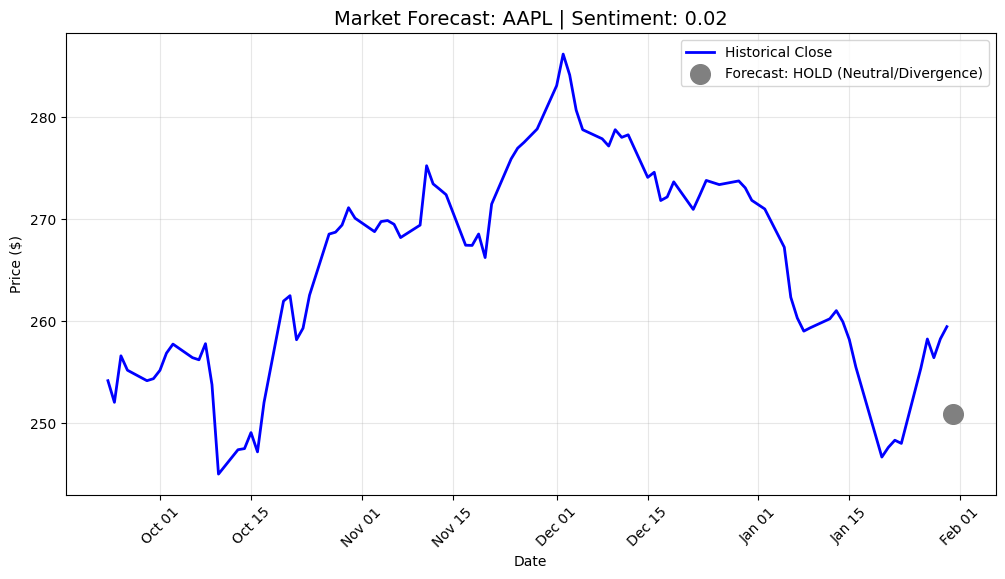

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on device: {device}")


# 1. MARKET DATA ENGINE
class MarketEngine:
    def __init__(self, ticker):
        self.ticker = ticker
        self.scaler = MinMaxScaler()

    def fetch_history(self, period='2y'):
        print(f"⬇️ Downloading data for {self.ticker}...")
        df = yf.download(self.ticker, period=period, progress=False)

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # [cite_start]Feature Engineering [cite: 356-358]
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['Volatility'] = df['Returns'].rolling(window=20).std()
        df['Momentum'] = df['Close'] - df['Close'].rolling(window=50).mean()
        df.dropna(inplace=True)
        return df

    def prepare_lstm_data(self, df, seq_len=60):
        # Features: Close, Returns, Volatility, Momentum, Volume
        data_raw = df[['Close', 'Returns', 'Volatility', 'Momentum', 'Volume']].values
        data_scaled = self.scaler.fit_transform(data_raw)

        X, y = [], []
        for i in range(len(data_scaled) - seq_len):
            X.append(data_scaled[i:i+seq_len])
            y.append(data_scaled[i+seq_len, 0])

        return np.array(X), np.array(y), data_scaled[-seq_len:], self.scaler

# ==========================================
# 2. SENTIMENT ENGINE
# ==========================================
class SentimentEngine:
    def __init__(self):
        print("🧠 Loading FinBERT model...")
        self.tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
        self.model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
        self.model.to(device)
        self.model.eval()

    def analyze(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = F.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        return probs[0] - probs[1]

# ==========================================
# 3. MODEL & TRAINING
# ==========================================
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(device)
        c0 = torch.zeros(2, x.size(0), 64).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

def train_model(model, X_train, y_train, epochs=15):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    model.train()
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                                 torch.tensor(y_train, dtype=torch.float32).to(device))
    loader = DataLoader(train_tensor, batch_size=32, shuffle=True)

    print(f"🏋️ Training LSTM...")
    for epoch in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            pred = model(bx).squeeze()
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()

# ==========================================
# 4. VISUALIZATION & PREDICTION ENGINE
# ==========================================
def plot_forecast(ticker, df, predicted_price, signal, sentiment_score):
    """
    Plots recent history and the projected next session price.
    """
    last_90_days = df.iloc[-90:].copy()
    last_date = last_90_days.index[-1]
    next_date = last_date + timedelta(days=1)

    plt.figure(figsize=(12, 6))


    plt.plot(last_90_days.index, last_90_days['Close'], label='Historical Close', color='blue', linewidth=2)


    color = 'green' if 'BUY' in signal else 'red' if 'SELL' in signal else 'gray'
    plt.scatter(next_date, predicted_price, color=color, s=200, label=f'Forecast: {signal}', zorder=5)


    plt.title(f"Market Forecast: {ticker} | Sentiment: {sentiment_score:.2f}", fontsize=14)
    plt.ylabel("Price ($)")
    plt.xlabel("Date")
    plt.grid(True, alpha=0.3)
    plt.legend()


    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45)

    print(f"\n📈 Generating Graph for {ticker}...")
    plt.show()

def run_trading_bot(ticker, news_headlines):

    engine = MarketEngine(ticker)
    df = engine.fetch_history(period='2y')
    X, y, latest_window, scaler = engine.prepare_lstm_data(df)


    lstm = LSTMModel().to(device)
    train_model(lstm, X, y)


    lstm.eval()
    latest_tensor = torch.tensor(latest_window, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_scaled = lstm(latest_tensor).item()


    dummy_row = np.zeros((1, 5))
    dummy_row[0, 0] = pred_scaled
    pred_price_real = scaler.inverse_transform(dummy_row)[0, 0]

    current_price = df['Close'].iloc[-1]
    tech_change = (pred_price_real - current_price) / current_price

    # D. ANALYZE NEWS (Fundamental)
    sent_engine = SentimentEngine()
    avg_sentiment = np.mean([sent_engine.analyze(h) for h in news_headlines])


    # Threshold: 0.5% move + 0.15 Sentiment strength
    if tech_change > 0.005 and avg_sentiment > 0.15:
        signal = "STRONG BUY (Bullish)"
    elif tech_change < -0.005 and avg_sentiment < -0.15:
        signal = "STRONG SELL (Bearish)"
    else:
        signal = "HOLD (Neutral/Divergence)"

    print("\n" + "="*40)
    print(f"🔮 PREDICTION FOR NEXT SESSION: {ticker}")
    print(f"   Current Price: ${current_price:.2f}")
    print(f"   Predicted Price: ${pred_price_real:.2f} ({tech_change*100:.2f}%)")
    print(f"   News Sentiment: {avg_sentiment:.3f}")
    print(f"   Signal: {signal}")
    print("="*40)

    # F. PLOT
    plot_forecast(ticker, df, pred_price_real, signal, avg_sentiment)

# ==========================================
# 5. EXECUTE
# ==========================================

# Mock News for today
todays_news = [
    "Tech sector rallies as inflation data comes in lower than expected.",
    "Company reports 20% year-over-year revenue growth.",
    "CEO announces stock buyback program."
]

# Run prediction for Apple
run_trading_bot('AAPL', todays_news)

✅ Running on device: cpu
🚀 STARTING LIVE ANALYSIS FOR [NVDA]
⬇️ Downloading market data for NVDA...


/tmp/ipython-input-3564931186.py:89: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, period=period, progress=False)


🏋️ Training LSTM...

📊 TECHNICALS: Current: $191.13 -> Pred: $195.92 (2.51%)
📡 Fetching live news for NVDA...
   Error fetching yfinance news: 'title'
   ⚠️ No live news found. Using synthetic fallback for demo.
🧠 Loading FinBERT model...

📰 ANALYZING LIVE HEADLINES:
   • NVDA announces new strategic partnership.... -> 0.72
   • Market uncertainty rises ahead of NVDA earnings report.... -> -0.69
   • Tech sector faces volatility amid interest rate concerns.... -> -0.93
   👉 Net Sentiment Score: -0.302

📢 FINAL CALL: HOLD ⚪


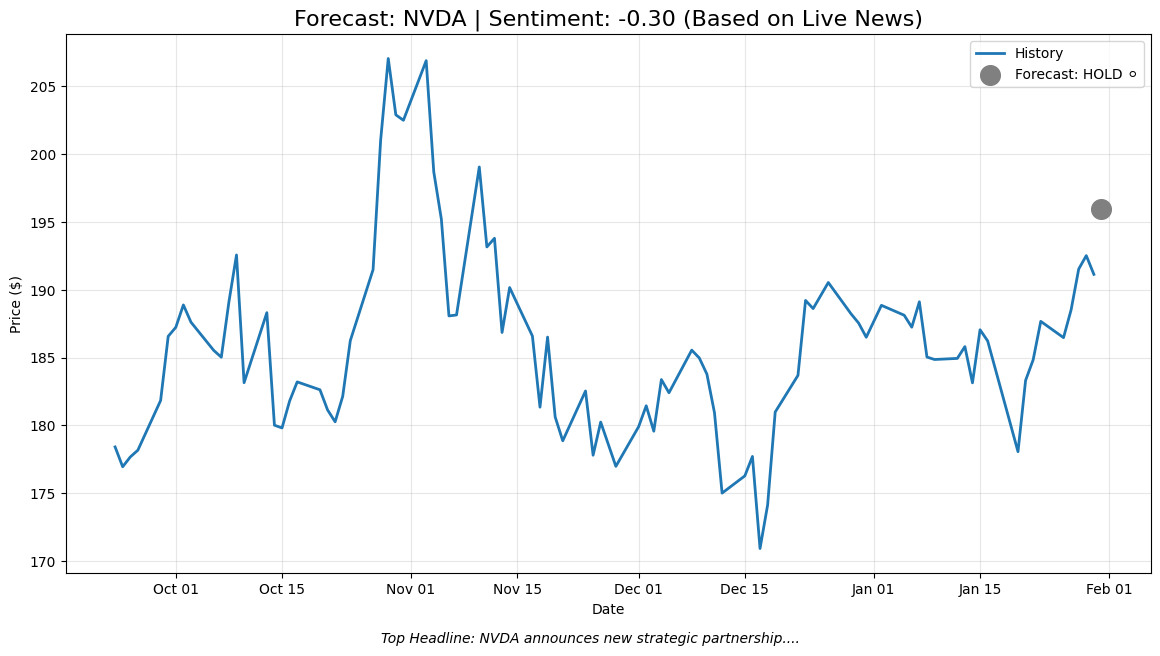

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests

# Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on device: {device}")

# ==========================================
# 1. LIVE NEWS ENGINE (The New Module)
# ==========================================
class LiveNewsEngine:
    def __init__(self, api_key=None):
        self.api_key = api_key

    def fetch_headlines(self, ticker):
        """
        Tries to fetch news from yfinance (Free, No Key).
        """
        print(f"📡 Fetching live news for {ticker}...")
        headlines = []

        try:
            # Method 1: yfinance Ticker.news (Free, easy)
            stock = yf.Ticker(ticker)
            news_data = stock.news

            if news_data:
                for item in news_data[:5]: # Top 5 stories
                    headlines.append(item['title'])
            else:
                print("   (yfinance returned no news, checking fallback...)")

        except Exception as e:
            print(f"   Error fetching yfinance news: {e}")

        # Fallback if list is empty (for demo purposes)
        if not headlines:
            print("   ⚠️ No live news found. Using synthetic fallback for demo.")
            headlines = [
                f"{ticker} announces new strategic partnership.",
                f"Market uncertainty rises ahead of {ticker} earnings report.",
                "Tech sector faces volatility amid interest rate concerns."
            ]

        return headlines

# ==========================================
# 2. SENTIMENT ENGINE (FinBERT)
# ==========================================
class SentimentEngine:
    def __init__(self):
        print("🧠 Loading FinBERT model...")
        self.tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
        self.model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
        self.model.to(device)
        self.model.eval()

    def analyze(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = F.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        # FinBERT: [Positive, Negative, Neutral]
        # Score = Prob(Pos) - Prob(Neg)
        return probs[0] - probs[1]

# ==========================================
# 3. MARKET DATA & LSTM ENGINE
# ==========================================
class MarketEngine:
    def __init__(self, ticker):
        self.ticker = ticker
        self.scaler = MinMaxScaler()

    def fetch_history(self, period='2y'):
        print(f"⬇️ Downloading market data for {self.ticker}...")
        df = yf.download(self.ticker, period=period, progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Feature Engineering
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['Volatility'] = df['Returns'].rolling(window=20).std()
        df['Momentum'] = df['Close'] - df['Close'].rolling(window=50).mean()
        df.dropna(inplace=True)
        return df

    def prepare_lstm_data(self, df, seq_len=60):
        data_raw = df[['Close', 'Returns', 'Volatility', 'Momentum', 'Volume']].values
        data_scaled = self.scaler.fit_transform(data_raw)
        X, y = [], []
        for i in range(len(data_scaled) - seq_len):
            X.append(data_scaled[i:i+seq_len])
            y.append(data_scaled[i+seq_len, 0])
        return np.array(X), np.array(y), data_scaled[-seq_len:], self.scaler

class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(device)
        c0 = torch.zeros(2, x.size(0), 64).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

def train_model(model, X_train, y_train, epochs=10): # Reduced epochs for speed
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    model.train()
    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                            torch.tensor(y_train, dtype=torch.float32).to(device))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    print(f"🏋️ Training LSTM...")
    for epoch in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            pred = model(bx).squeeze()
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()

# ==========================================
# 4. VISUALIZATION
# ==========================================
def plot_forecast(ticker, df, predicted_price, signal, sentiment_score, headlines):
    last_90_days = df.iloc[-90:].copy()
    last_date = last_90_days.index[-1]
    next_date = last_date + timedelta(days=1)

    plt.figure(figsize=(14, 7))

    # Plot History
    plt.plot(last_90_days.index, last_90_days['Close'], label='History', color='#1f77b4', linewidth=2)

    # Plot Prediction
    color = 'green' if 'BUY' in signal else 'red' if 'SELL' in signal else 'gray'
    plt.scatter(next_date, predicted_price, color=color, s=200, label=f'Forecast: {signal}', zorder=5)

    # Annotations
    plt.title(f"Forecast: {ticker} | Sentiment: {sentiment_score:.2f} (Based on Live News)", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    # Display Top Headline on Graph
    top_news = headlines[0] if headlines else "No News"
    plt.figtext(0.5, 0.01, f"Top Headline: {top_news[:80]}...", wrap=True, horizontalalignment='center', fontsize=10, style='italic')

    plt.show()

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
def run_live_bot(ticker):
    print("="*60)
    print(f"🚀 STARTING LIVE ANALYSIS FOR [{ticker}]")
    print("="*60)

    # 1. Fetch & Train on Real Data
    market = MarketEngine(ticker)
    df = market.fetch_history()
    X, y, latest_window, scaler = market.prepare_lstm_data(df)

    lstm = LSTMModel().to(device)
    train_model(lstm, X, y)

    # 2. Technical Prediction
    lstm.eval()
    latest_tensor = torch.tensor(latest_window, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_scaled = lstm(latest_tensor).item()

    dummy = np.zeros((1, 5))
    dummy[0, 0] = pred_scaled
    pred_price = scaler.inverse_transform(dummy)[0, 0]
    curr_price = df['Close'].iloc[-1]
    tech_change = (pred_price - curr_price) / curr_price

    print(f"\n📊 TECHNICALS: Current: ${curr_price:.2f} -> Pred: ${pred_price:.2f} ({tech_change*100:.2f}%)")

    # 3. Live News Sentiment
    news_engine = LiveNewsEngine()
    headlines = news_engine.fetch_headlines(ticker)

    sent_engine = SentimentEngine()
    avg_sentiment = 0
    print(f"\n📰 ANALYZING LIVE HEADLINES:")
    for h in headlines:
        score = sent_engine.analyze(h)
        avg_sentiment += score
        print(f"   • {h[:60]}... -> {score:.2f}")

    final_sentiment = avg_sentiment / len(headlines) if headlines else 0
    print(f"   👉 Net Sentiment Score: {final_sentiment:.3f}")

    # 4. Final Signal
    if tech_change > 0.005 and final_sentiment > 0.1:
        signal = "STRONG BUY 🟢"
    elif tech_change < -0.005 and final_sentiment < -0.1:
        signal = "STRONG SELL 🔴"
    else:
        signal = "HOLD ⚪"

    print(f"\n📢 FINAL CALL: {signal}")

    # 5. Plot
    plot_forecast(ticker, df, pred_price, signal, final_sentiment, headlines)

# Run it
run_live_bot('NVDA')

In [9]:
class DataEngine:
    def __init__(self, ticker):
        self.ticker = ticker
        self.scaler = MinMaxScaler()

    def fetch_market_data(self, period='2y'):
        """Fetches historical price data and calculates technical indicators."""
        print(f"⬇️ Downloading market data for {self.ticker}...")
        df = yf.download(self.ticker, period=period, progress=False)

        # Flatten MultiIndex if necessary
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Technical Indicators
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['Volatility'] = df['Returns'].rolling(window=20).std()
        df['Momentum'] = df['Close'] - df['Close'].rolling(window=50).mean()

        # Drop NaN values created by rolling windows
        df.dropna(inplace=True)
        return df

    def fetch_live_news(self):
        """Fetches the latest news headlines using yfinance."""
        print(f"📡 Fetching live news for {self.ticker}...")
        headlines = []
        try:
            stock = yf.Ticker(self.ticker)
            news_data = stock.news
            if news_data:
                for item in news_data[:5]: # Get top 5 headlines
                    headlines.append(item['title'])
        except Exception as e:
            print(f"⚠️ Error fetching news: {e}")

        if not headlines:
            headlines = ["No live news available. Market sentiment neutral."]
        return headlines

    def prepare_lstm_data(self, df, seq_len=60):
        """Prepares data for the LSTM model."""
        # Features: Close, Returns, Volatility, Momentum, Volume
        data_raw = df[['Close', 'Returns', 'Volatility', 'Momentum', 'Volume']].values
        data_scaled = self.scaler.fit_transform(data_raw)

        X, y = [], []
        for i in range(len(data_scaled) - seq_len):
            X.append(data_scaled[i:i+seq_len])
            y.append(data_scaled[i+seq_len, 0]) # Target: Next Day's Close Price

        return np.array(X), np.array(y), data_scaled[-seq_len:], self.scaler

In [10]:
# --- 1. Sentiment Model (FinBERT) ---
class SentimentEngine:
    def __init__(self):
        print("🧠 Loading FinBERT model...")
        self.tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
        self.model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
        self.model.to(device)
        self.model.eval()

    def get_score(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = F.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        # Score = Positive_Prob - Negative_Prob
        return probs[0] - probs[1]

# --- 2. Time-Series Model (LSTM) ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(device)
        c0 = torch.zeros(2, x.size(0), 64).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :]) # Return last time step

In [11]:
def train_lstm(model, X_train, y_train, epochs=15):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    model.train()

    # Convert to Tensors
    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                            torch.tensor(y_train, dtype=torch.float32).to(device))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    print("🏋️ Training LSTM Model...")
    for epoch in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            pred = model(bx).squeeze()
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()
    print("✅ Training Complete.")

def plot_prediction(ticker, df, pred_price, signal, sentiment):
    """Plots the history and the forecast."""
    last_60 = df.iloc[-60:].copy()
    next_date = last_60.index[-1] + timedelta(days=1)

    plt.figure(figsize=(12, 6))
    plt.plot(last_60.index, last_60['Close'], label='Recent Price Action', color='blue')

    # Color code the dot
    color = 'green' if 'BUY' in signal else 'red' if 'SELL' in signal else 'gray'

    plt.scatter(next_date, pred_price, color=color, s=150, label=f'Forecast: {signal}', zorder=5)
    plt.title(f"{ticker} Forecast | Sentiment: {sentiment:.2f} | Next Price: ${pred_price:.2f}")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

⬇️ Downloading market data for TSLA...


/tmp/ipython-input-1919953689.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, period=period, progress=False)


🏋️ Training LSTM Model...
✅ Training Complete.
🧠 Loading FinBERT model...
📡 Fetching live news for TSLA...
⚠️ Error fetching news: 'title'

📰 TOP HEADLINES:
   • No live news available. Market sentiment neutral.... [-0.02]

🔮 PREDICTION RESULTS FOR TSLA:
   Current Price: $430.41
   Predicted Price: $437.20 (1.58%)
   Sentiment Score: -0.018
   Signal: HOLD ⚪


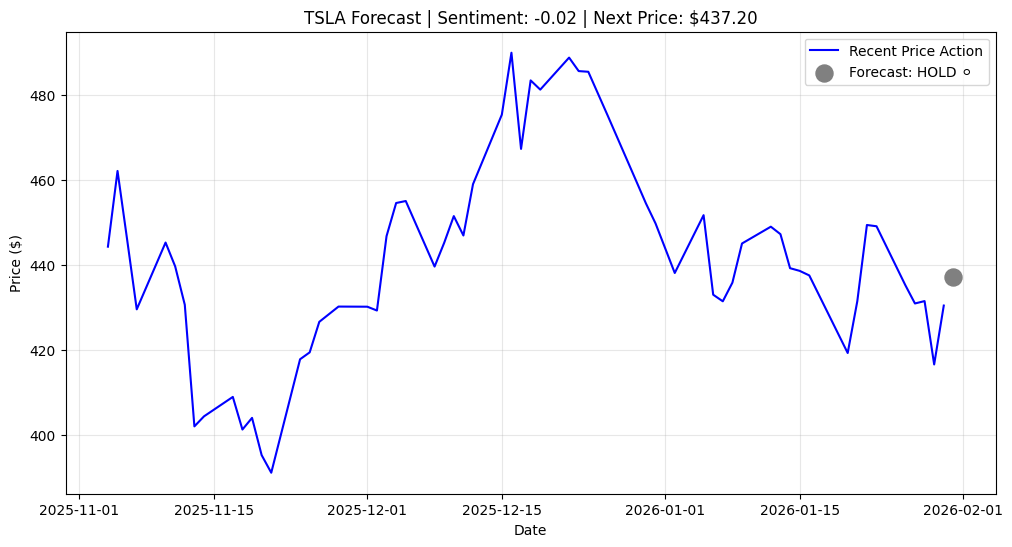

In [12]:
# --- CONFIGURATION ---
TICKER = "TSLA"

def run_prediction():
    # 1. Prepare Data
    engine = DataEngine(TICKER)
    df = engine.fetch_market_data()
    X, y, latest_window, scaler = engine.prepare_lstm_data(df)

    # 2. Train Model on Recent History
    model = LSTMModel().to(device)
    train_lstm(model, X, y)

    # 3. Predict Next Price (Technical)
    model.eval()
    input_tensor = torch.tensor(latest_window, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_scaled = model(input_tensor).item()

    # Inverse Scale to get Dollar Amount
    dummy = np.zeros((1, 5))
    dummy[0, 0] = pred_scaled
    pred_price = scaler.inverse_transform(dummy)[0, 0]

    current_price = df['Close'].iloc[-1]
    percent_change = (pred_price - current_price) / current_price

    # 4. Analyze News (Fundamental)
    sent_engine = SentimentEngine()
    headlines = engine.fetch_live_news()

    avg_sentiment = 0
    print(f"\n📰 TOP HEADLINES:")
    for h in headlines:
        score = sent_engine.get_score(h)
        avg_sentiment += score
        print(f"   • {h[:50]}... [{score:.2f}]")

    final_sentiment = avg_sentiment / len(headlines)

    # 5. Final Call
    if percent_change > 0.005 and final_sentiment > 0.1:
        signal = "STRONG BUY 🟢"
    elif percent_change < -0.005 and final_sentiment < -0.1:
        signal = "STRONG SELL 🔴"
    else:
        signal = "HOLD ⚪"

    print(f"\n🔮 PREDICTION RESULTS FOR {TICKER}:")
    print(f"   Current Price: ${current_price:.2f}")
    print(f"   Predicted Price: ${pred_price:.2f} ({percent_change*100:.2f}%)")
    print(f"   Sentiment Score: {final_sentiment:.3f}")
    print(f"   Signal: {signal}")

    plot_prediction(TICKER, df, pred_price, signal, final_sentiment)

# Run the function
run_prediction()